In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

In [2]:
#### Load true and false flares data
# Load dataframes
true_flares_df = pd.read_csv('../Chandra_data/trueflares.csv')
false_flares_df = pd.read_csv('../Chandra_data/falseflares.csv')
true_flares_df = true_flares_df[['time','energy','obsreg_id']]
false_flares_df = false_flares_df[['time','energy','obsreg_id']]

# Convert to data dictionary
d = true_flares_df.groupby('obsreg_id').apply(lambda group: (1,np.array(group[['time', 'energy']]))).to_dict()
d.update(false_flares_df.groupby('obsreg_id').apply(lambda group: (0,np.array(group[['time', 'energy']]))).to_dict())

In [3]:
# Prepare for data, drop the outliers
data_lst = []
lengths = []
Ts = []
length_threshold = 5000
T_threshold = 250000
t_scale = 5000
for key in list(d.keys()):
    event_class = d[key][0]
    event_list = d[key][1]
    length = len(event_list)
    event_list[:,0] = event_list[:,0] - min(event_list[:,0])
    T = max(event_list[:,0]) - min(event_list[:,0])
    if length > length_threshold or T > T_threshold:
        continue
    else:
        lengths.append(length)
        Ts.append(T)
        data_lst.append({'class':event_class,'event_list':event_list})
lengths = np.array(lengths)
Ts = np.array(Ts)

In [4]:
# append another class, containing all halved event lists
N = len(data_lst)
for n in range(N):
    times = data_lst[n]['event_list']
    event_class = data_lst[n]['class']
    T = max(times[:,0])
    indices = times[:,0] < T / 2
    data_lst.append({'class':event_class+2,'event_list':times[indices,:]})

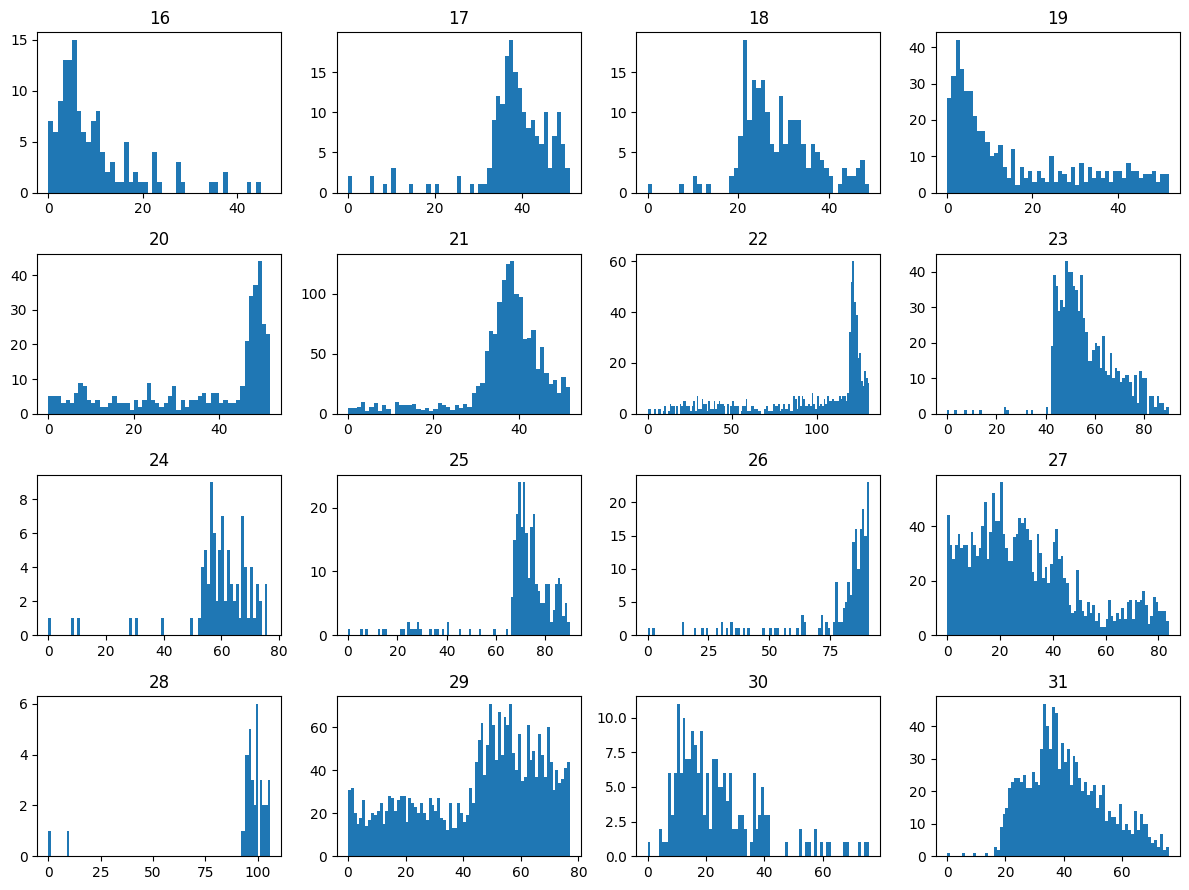

In [5]:
# Visualizations
# # Visualization
# fig, ax = plt.subplots(1,2)
# ax[0].hist(lengths,bins=20);
# ax[0].set_title('Event list lengths')

# ax[1].hist(Ts,bins=20);
# ax[1].set_title('Event list time range')
# plt.tight_layout()

def visualize_hist(times, t_scale):
    times = times / t_scale
    plt.hist(times, bins = np.arange(np.ceil(max(times))))

plt.figure(figsize=(12,9))
start_index = 16
for i in range(16):
    index = start_index + i
    plt.subplot(4,4,i+1)
    plt.title(index)
    visualize_hist(data_lst[index]['event_list'][:,0],t_scale/10)
plt.tight_layout()
# plt.savefig('../plots/total_rate_comparison.png')
plt.show()



In [6]:
# Record special labels
B = 16
data = RealEventsDataset(data_lst,t_scale=t_scale)
loader = DataLoader(data, batch_size=B, shuffle=True, num_workers=4, collate_fn=padding_collate_fn)

In [7]:
# Create and save NN model
num_freqs = 12
num_latent = 30
E_bins = 13
encoding = PositionalEncoding(num_freqs=num_freqs)
model = AutoEncoder('lstm', num_latent, encoding, hidden_size=512, E_bins=E_bins, lam_TV=0.2, lam_latent=0,
                        d_encoder_model=48, nhead=4, dim_feedforward=512)
model.load_state_dict(torch.load('../models/lstm_800epochs_lamTV02.pth'));
model.to(device);

In [8]:
# Test data, currently just the training data
test_loader = DataLoader(data, batch_size=B, collate_fn=padding_collate_fn)
outputs = []
for idx, batch in enumerate(test_loader):
    batch = todevice(batch, device)
    outputs.append(todevice(model(batch),'cpu'))

def output_collate_fn(outputs):
    '''
    Outputs is a list of dic
    '''
    output = {}
    for key in outputs[0].keys():
        if key in ['latent','T','num_events','class']:
            output[key] = torch.cat([o[key] for o in outputs], dim=0)
        # elif key == 'class':
        #     output[key] = sum([o[key] for o in outputs],[])
        else:
            output[key] = [o[key] for o in outputs]
    return output

collated_outputs = output_collate_fn(outputs)
collated_outputs['num_events_per'] = collated_outputs['num_events'] / collated_outputs['T']

## PCA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'PCA of latent representations')

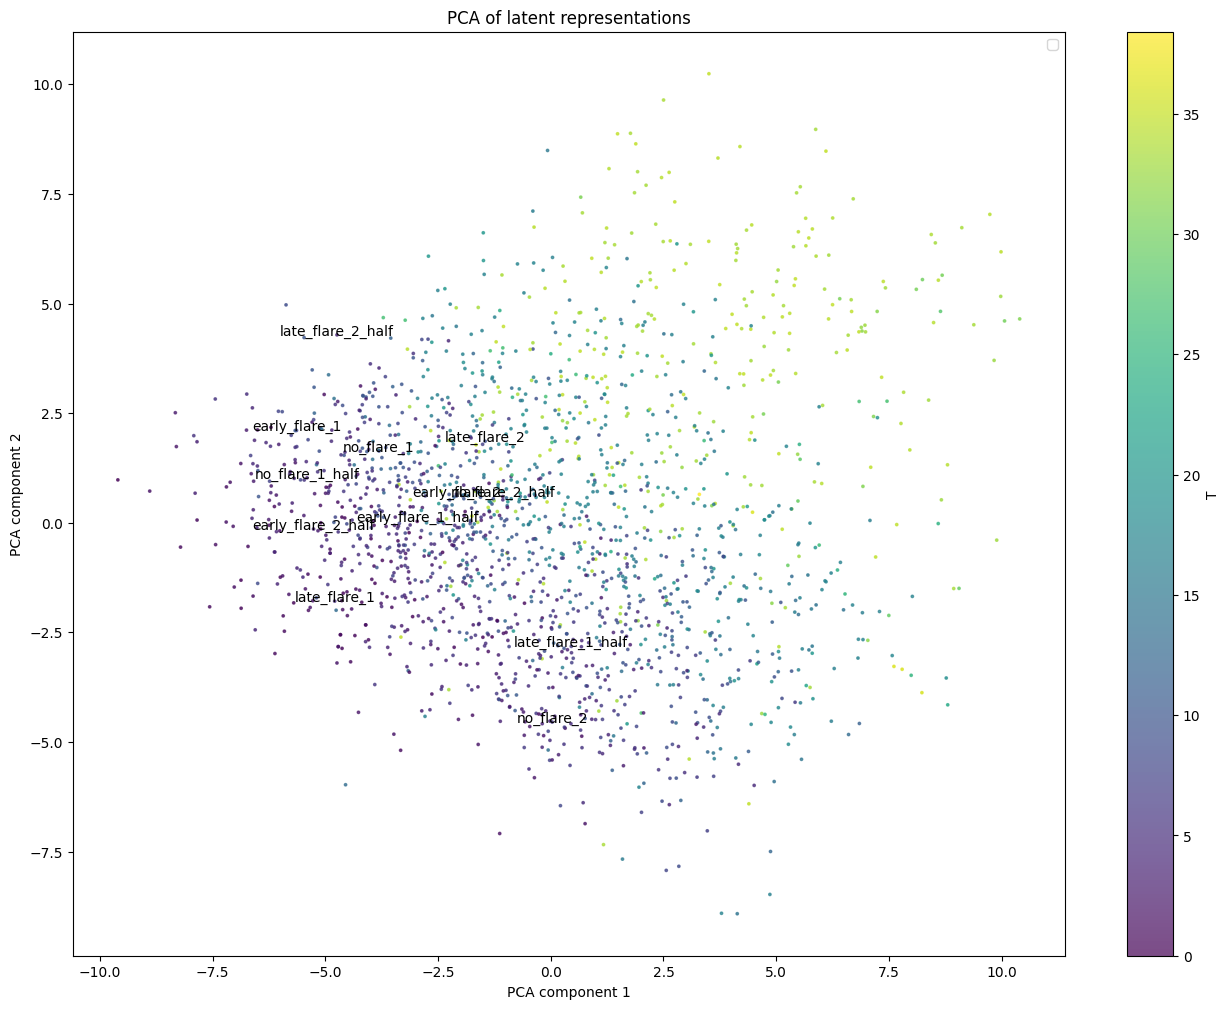

In [14]:
metric = 'T'

# Continuous metric
##### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z = collated_outputs['latent']
embedding = pca.fit_transform(z)

plt.figure(figsize=(16,12))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=collated_outputs[metric], cmap='viridis', alpha=0.7, 
            marker='o',s=3, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
plt.colorbar(scatter, label=metric)

special_labels = {'late_flare_1':22,
                 'late_flare_2':20,
                  'early_flare_1':16,
                  'early_flare_2':19,
                 'no_flare_1':612,
                 'no_flare_2':614,
                 'late_flare_1_half':22+N,
                 'late_flare_2_half':20+N,
                  'early_flare_1_half':16+N,
                  'early_flare_2_half':19+N,
                 'no_flare_1_half':612+N,
                 'no_flare_2_half':614+N,}
for k, v in special_labels.items():
    x, y = embedding[v, :]  # 15th point (indexing starts from 0)
    plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,0), ha='center')

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend(loc='best')
plt.title('PCA of latent representations')
# plt.savefig(f'../plots/PCA_{metric}.png')


# pca = PCA(n_components=2)
# z = collated_outputs['latent']
# embedding = pca.fit_transform(z)

# # Define binary color map
# colors = ['red', 'blue']  # Choose colors that suit your preference
# labels = ['Group 0', 'Group 1']  # Replace with meaningful group names

# plt.figure(figsize=(8, 6))
# for group in [0, 1]:
#     idx = (collated_outputs[metric] == group)
#     plt.scatter(embedding[idx, 0], embedding[idx, 1], c=colors[group], label=labels[group], 
#                 alpha=0.7, marker='o', s=3)

# plt.xlabel('PCA component 1')
# plt.ylabel('PCA component 2')
# plt.legend(loc='best')
# plt.title('PCA of latent representations')
# plt.savefig(f'../plots/PCA_{metric}.png')

## t-SNE

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 1886
Input similarities computed in 0.40 seconds (sparsity = 0.064025)!
Learning embedding...
Iteration 50: error is 77.967042 (50 iterations in 1.14 seconds)
Iteration 100: error is 75.016102 (50 iterations in 1.43 seconds)
Iteration 150: error is 74.246906 (50 iterations in 0.75 seconds)
Iteration 200: error is 74.243480 (50 iterations in 0.70 seconds)
Iteration 250: error is 3.702066 (50 iterations in 0.70 seconds)
Iteration 300: error is 1.787385 (50 iterations in 0.64 seconds)
Iteration 350: error is 1.556078 (50 iterations in 0.66 seconds)
Iteration 400: error is 1.467523 (50 iterations in 0.69 seconds)
Iteration 450: error is 1.426242 (50 iterations in 0.69 seconds)
Iteration 500: error is 1.405580 (50 iterations in 0.69 seconds)
Iteration 550: error is 1.393184 (50 iterations in 0.69 seconds)
Iteration 600: error is 

Text(0.5, 1.0, 'tSNE of latent representations')

Iteration 999: error is 1.360414 (50 iterations in 0.69 seconds)
Fitting performed in 15.02 seconds.


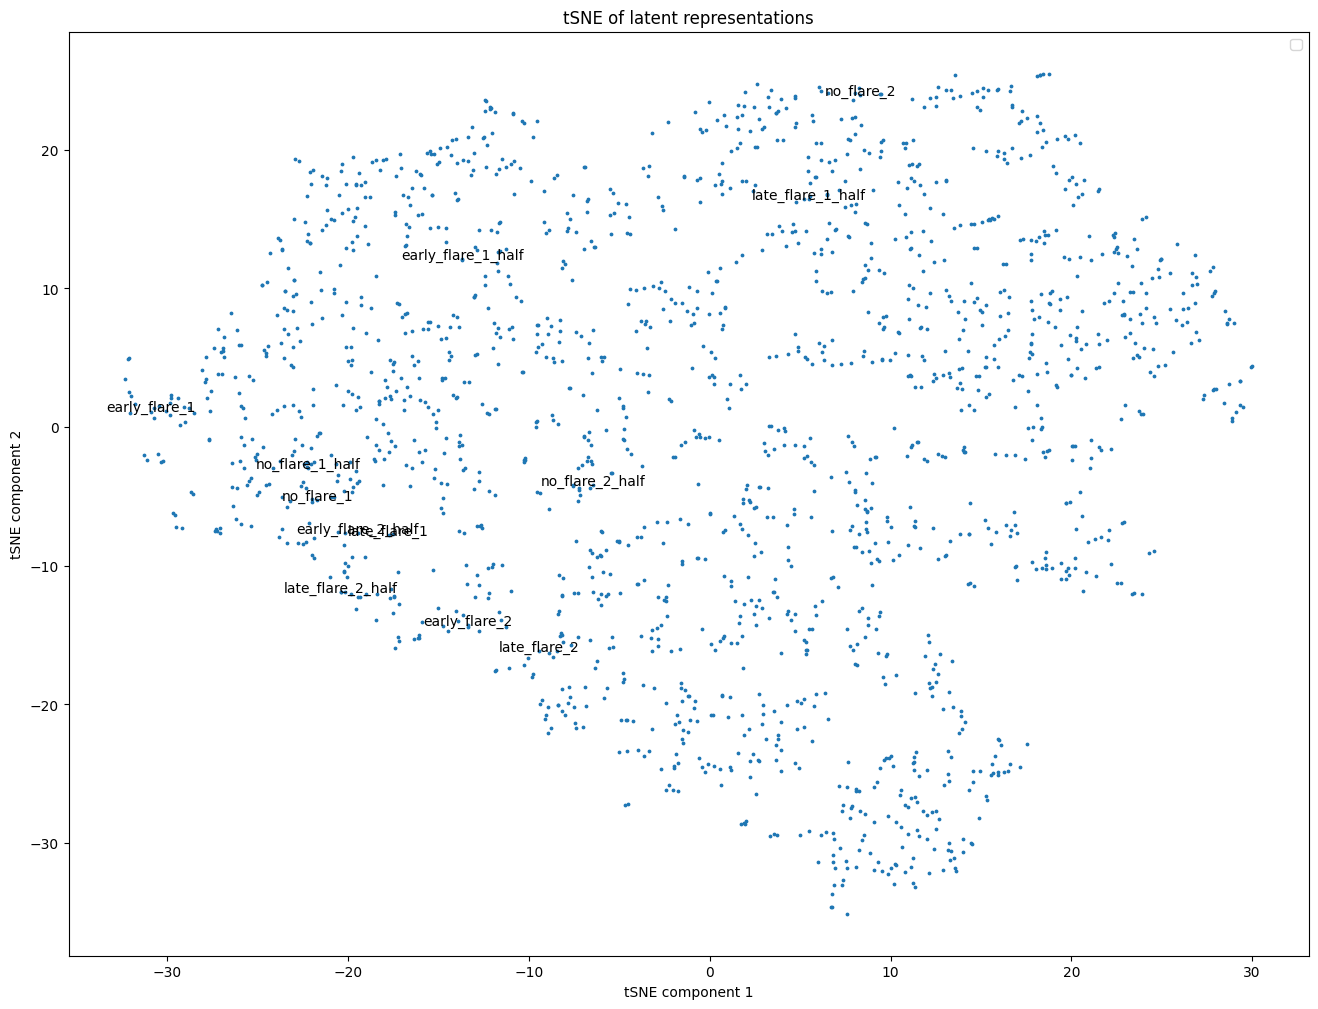

In [16]:
# from bhtsne import tsne
# data_nd_tsne = tsne(z.numpy().astype(np.float64))

# labels = collated_outputs['class'].numpy()
# unique_labels = np.unique(labels)
# colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

# plt.figure(figsize=(16, 12))
# for i, label in enumerate(unique_labels):
#     idx = labels == label
#     plt.scatter(data_nd_tsne[idx, 0], data_nd_tsne[idx, 1], color=colors[i], label=label, marker='o',s=3)

# plt.xlabel('tSNE component 1')
# plt.ylabel('tSNE component 2')
# plt.legend(loc='best')
# plt.title('tSNE of latent representations')
# plt.savefig(f'../plots/tSNE.png')

from bhtsne import tsne
data_nd_tsne = tsne(z.numpy().astype(np.float64))

plt.figure(figsize=(16, 12))
plt.scatter(data_nd_tsne[:, 0], data_nd_tsne[:, 1], marker='o',s=3)

for k, v in special_labels.items():
    x, y = data_nd_tsne[v, :]  # 15th point (indexing starts from 0)
    plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,0), ha='center')

plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
plt.legend(loc='best')
plt.title('tSNE of latent representations')
# plt.savefig(f'../plots/tSNE.png')




## Single dimension visualization

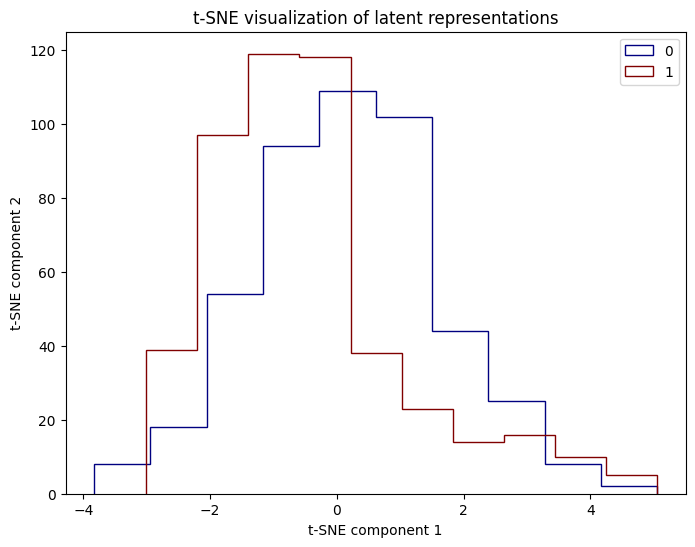

In [67]:
labels = collated_outputs['class'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.hist(z[idx, 1], color=colors[i], histtype='step', label=label)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(loc='best')
plt.title('t-SNE visualization of latent representations')
plt.show()

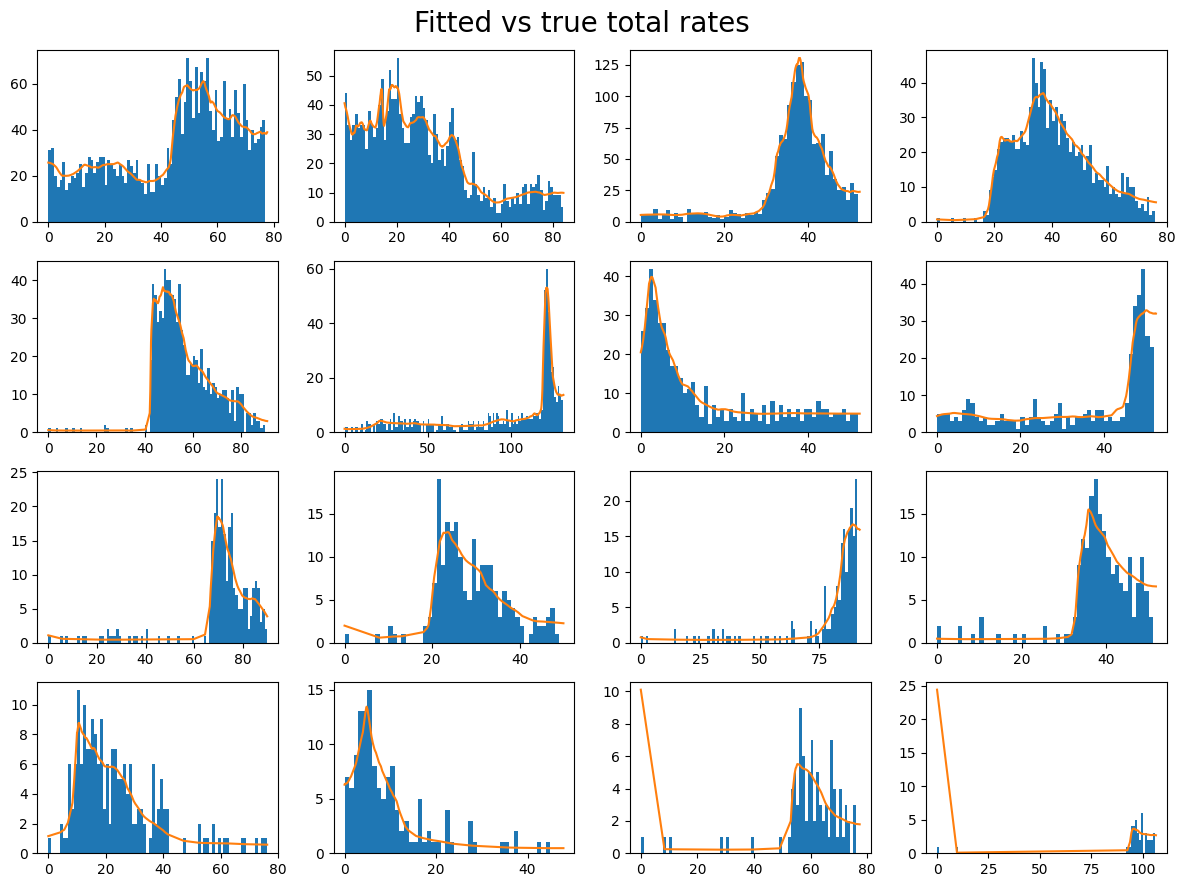

In [13]:
plotting_t_scale = 10

# Plot total rates
plt.figure(figsize=(12,9))
batch_index = 1
start_index = 0
for i in range(16):
    index = start_index + i
    batch = outputs[batch_index]
    mask = batch['mask'][index]
    times = batch['event_list'][index,mask,0] * plotting_t_scale
    rates = batch['rates'][index,mask] / plotting_t_scale
    T = batch['T'][index] * plotting_t_scale
    plt.subplot(4,4,i+1)
    plt.hist(times, bins = torch.arange(torch.ceil(T)))
    plt.plot(times, torch.sum(rates,dim=-1))
    # plt.xlabel('t (rescaled for better visualization)')
    # plt.ylabel('rate')
plt.suptitle('Fitted vs true total rates',size=20)
plt.tight_layout()
# plt.savefig('../plots/total_rate_comparison.png')
plt.show()




In [18]:
sum(mask==True)

tensor(44)

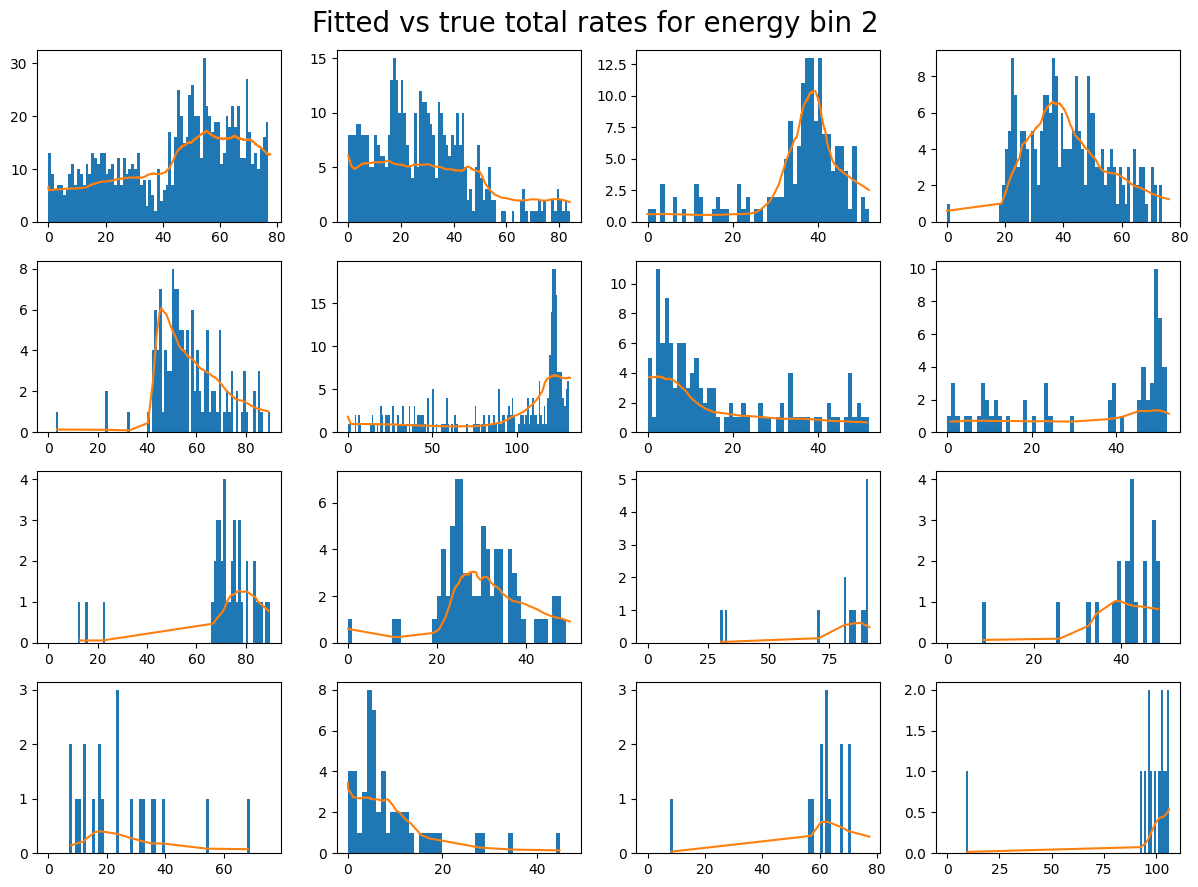

In [23]:
# Plot rates for a specific energy bin
plt.figure(figsize=(12,9))
batch_index = 1
start_index = 0
E_index = 1
for i in range(16):
    index = start_index + i
    batch = outputs[batch_index]
    mask = batch['mask'][index]
    times = batch['event_list'][index,mask,:]
    E_mask = times[:,E_index+1]==1
    times = times[E_mask,0] * plotting_t_scale
    rates = batch['rates'][index,mask,E_index]
    rates = rates[E_mask] / plotting_t_scale
    T = batch['T'][index] * plotting_t_scale
    
    plt.subplot(4,4,i+1)
    plt.hist(times, bins = torch.arange(torch.ceil(T)))
    plt.plot(times, rates)
plt.suptitle(f'Fitted vs true total rates for energy bin {E_index+1}',size=20)
plt.tight_layout()
plt.savefig(f'../plots/total_rate_comparison_E{E_index+1}.png')
plt.show()